### Open this notebook in nbviewer to view all the contents - https://nbviewer.jupyter.org/

# Part 3 ‑ Predictive modeling

<font color = 'red'>Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed
description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its longterm rider retention (again, a few sentences will suffice).</font>
Data description
<font color = 'blue'> 
● city: city this user signed up in
● phone: primary device for this user
● signup_date: date of account registration; in the form ‘YYYY MM DD’
● last_trip_date: the last time this user completed a trip; in the form ‘YYYY MM DD’
● avg_dist: the average distance in miles per trip taken in the first 30 days after signup
● avg_rating_by_driver: the rider’s average rating over all of their trips
● avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips
● surge_pct: the percent of trips taken with surge multiplier > 1
● avg_surge: The average surge multiplier over all of this user’s trips
● trips_in_first_30_days: the number of trips this user took in the first 30 days after
signing up
● ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days;
FALSE otherwise
● weekday_pct: the percent of the user’s trips occurring during a weekday * </font>

In [2]:
import pandas as pd

import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
%matplotlib widget
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.metrics import confusion_matrix

In [75]:
data = pd.read_json('./ultimate_data_challenge.json')
data.head()

city  trips_in_first_30_days signup_date  avg_rating_of_driver  \
0  King's Landing                       4  2014-01-25                   4.7   
1         Astapor                       0  2014-01-29                   5.0   
2         Astapor                       3  2014-01-06                   4.3   
3  King's Landing                       9  2014-01-10                   4.6   
4      Winterfell                      14  2014-01-27                   4.4   

   avg_surge last_trip_date    phone  surge_pct  ultimate_black_user  \
0       1.10     2014-06-17   iPhone       15.4                 True   
1       1.00     2014-05-05  Android        0.0                False   
2       1.00     2014-01-07   iPhone        0.0                False   
3       1.14     2014-06-29   iPhone       20.0                 True   
4       1.19     2014-03-15  Android       11.8                False   

   weekday_pct  avg_dist  avg_rating_by_driver  
0         46.2      3.67                   5.0  
1         50.0      8.26                   5.0  
2        100.0      0.77                   5.0  
3         80.0      2.36                   4.9  
4         82.4      3.13                   4.9

In [77]:
import pandas_profiling
data_report = pandas_profiling.ProfileReport(data)
data_report

<font color='green'>From the above report we see the following - 
    
1. There are 8 duplicate rows and 8719 missing columns
    
2. There are 4 categorical variables

3. The data is from 3 cities 

4. Avg_Rating_of_driver (8122), avg_rating_by_driver(201), phone (396) have missing values.  
</font>


In [4]:
data.describe()

trips_in_first_30_days  avg_rating_of_driver     avg_surge  \
count            50000.000000          41878.000000  50000.000000   
mean                 2.278200              4.601559      1.074764   
std                  3.792684              0.617338      0.222336   
min                  0.000000              1.000000      1.000000   
25%                  0.000000              4.300000      1.000000   
50%                  1.000000              4.900000      1.000000   
75%                  3.000000              5.000000      1.050000   
max                125.000000              5.000000      8.000000   

          surge_pct   weekday_pct      avg_dist  avg_rating_by_driver  
count  50000.000000  50000.000000  50000.000000          49799.000000  
mean       8.849536     60.926084      5.796827              4.778158  
std       19.958811     37.081503      5.707357              0.446652  
min        0.000000      0.000000      0.000000              1.000000  
25%        0.000000     33.300000      2.420000              4.700000  
50%        0.000000     66.700000      3.880000              5.000000  
75%        8.600000    100.000000      6.940000              5.000000  
max      100.000000    100.000000    160.960000              5.000000

In [ ]:
# Lets start by Data cleaning

In [5]:
#Identify duplicates
dup = data[data.duplicated(keep=False)]
dup

city  trips_in_first_30_days signup_date  avg_rating_of_driver  \
116    Winterfell                       1  2014-01-10                   5.0   
332       Astapor                       1  2014-01-18                   5.0   
2608      Astapor                       1  2014-01-18                   5.0   
3134      Astapor                       1  2014-01-20                   5.0   
5958   Winterfell                       1  2014-01-18                   NaN   
7836      Astapor                       1  2014-01-11                   5.0   
10624  Winterfell                       1  2014-01-18                   5.0   
14990  Winterfell                       1  2014-01-18                   NaN   
18057     Astapor                       1  2014-01-11                   5.0   
26709  Winterfell                       1  2014-01-01                   NaN   
29601  Winterfell                       1  2014-01-01                   NaN   
34641  Winterfell                       1  2014-01-18                   NaN   
36627  Winterfell                       1  2014-01-18                   5.0   
39601  Winterfell                       1  2014-01-10                   5.0   
42025  Winterfell                       1  2014-01-18                   NaN   
45416     Astapor                       1  2014-01-20                   5.0   

       avg_surge last_trip_date    phone  surge_pct  ultimate_black_user  \
116          1.0     2014-01-11  Android        0.0                False   
332          1.0     2014-01-19   iPhone        0.0                 True   
2608         1.0     2014-01-19   iPhone        0.0                 True   
3134         1.0     2014-01-20   iPhone        0.0                False   
5958         1.0     2014-01-19  Android        0.0                False   
7836         1.0     2014-01-11   iPhone        0.0                 True   
10624        1.0     2014-01-19  Android        0.0                False   
14990        1.0     2014-01-19   iPhone        0.0                 True   
18057        1.0     2014-01-11   iPhone        0.0                 True   
26709        1.0     2014-01-02  Android        0.0                False   
29601        1.0     2014-01-02  Android        0.0                False   
34641        1.0     2014-01-19   iPhone        0.0                 True   
36627        1.0     2014-01-19  Android        0.0                False   
39601        1.0     2014-01-11  Android        0.0                False   
42025        1.0     2014-01-19  Android        0.0                False   
45416        1.0     2014-01-20   iPhone        0.0                False   

       weekday_pct  avg_dist  avg_rating_by_driver  
116          100.0      0.00                   5.0  
332            0.0      6.25                   5.0  
2608           0.0      6.25                   5.0  
3134         100.0      3.06                   5.0  
5958           0.0      0.01                   5.0  
7836           0.0      2.33                   5.0  
10624          0.0      3.54                   5.0  
14990          0.0      1.44                   5.0  
18057          0.0      2.33                   5.0  
26709        100.0      8.08                   5.0  
29601        100.0      8.08                   5.0  
34641          0.0      1.44                   5.0  
36627          0.0      3.54                   5.0  
39601        100.0      0.00                   5.0  
42025          0.0      0.01                   5.0  
45416        100.0      3.06                   5.0

In [6]:
# Remove duplicates
data = data.drop_duplicates()
len(data)

49992

In [7]:
#null values
null_data = data[data.isnull().any(axis=1)]
null_data

city  trips_in_first_30_days signup_date  avg_rating_of_driver  \
6         Astapor                       1  2014-01-24                   NaN   
9      Winterfell                       1  2014-01-03                   NaN   
12     Winterfell                       1  2014-01-15                   NaN   
14        Astapor                       1  2014-01-27                   NaN   
15     Winterfell                       1  2014-01-15                   NaN   
...           ...                     ...         ...                   ...   
49984  Winterfell                       1  2014-01-26                   NaN   
49985     Astapor                       1  2014-01-26                   NaN   
49989  Winterfell                       1  2014-01-24                   NaN   
49996     Astapor                       1  2014-01-24                   NaN   
49999     Astapor                       0  2014-01-18                   NaN   

       avg_surge last_trip_date    phone  surge_pct  ultimate_black_user  \
6            1.0     2014-01-25  Android        0.0                False   
9            1.0     2014-01-05  Android        0.0                False   
12           1.0     2014-03-12   iPhone        0.0                False   
14           1.0     2014-01-28  Android        0.0                False   
15           1.0     2014-01-16  Android        0.0                 True   
...          ...            ...      ...        ...                  ...   
49984        1.0     2014-01-26  Android        0.0                False   
49985        1.0     2014-02-25  Android        0.0                False   
49989        1.0     2014-01-31   iPhone        0.0                False   
49996        1.0     2014-01-25   iPhone        0.0                False   
49999        1.0     2014-04-20  Android        0.0                False   

       weekday_pct  avg_dist  avg_rating_by_driver  
6            100.0      3.95                   4.0  
9              0.0      2.37                   5.0  
12           100.0     20.29                   5.0  
14           100.0     26.01                   5.0  
15           100.0     13.20                   5.0  
...            ...       ...                   ...  
49984          0.0      3.50                   5.0  
49985        100.0      1.38                   5.0  
49989        100.0      0.00                   5.0  
49996          0.0      0.00                   4.0  
49999          0.0      3.49                   5.0  

[8552 rows x 12 columns]

In [8]:
# Remove rows with missing values
data = data.dropna()
data

city  trips_in_first_30_days signup_date  \
0      King's Landing                       4  2014-01-25   
1             Astapor                       0  2014-01-29   
2             Astapor                       3  2014-01-06   
3      King's Landing                       9  2014-01-10   
4          Winterfell                      14  2014-01-27   
...               ...                     ...         ...   
49993         Astapor                       3  2014-01-03   
49994         Astapor                       1  2014-01-03   
49995  King's Landing                       0  2014-01-25   
49997      Winterfell                       0  2014-01-31   
49998         Astapor                       2  2014-01-14   

       avg_rating_of_driver  avg_surge last_trip_date    phone  surge_pct  \
0                       4.7       1.10     2014-06-17   iPhone       15.4   
1                       5.0       1.00     2014-05-05  Android        0.0   
2                       4.3       1.00     2014-01-07   iPhone        0.0   
3                       4.6       1.14     2014-06-29   iPhone       20.0   
4                       4.4       1.19     2014-03-15  Android       11.8   
...                     ...        ...            ...      ...        ...   
49993                   4.8       1.11     2014-07-01   iPhone       11.1   
49994                   4.6       1.44     2014-05-31   iPhone       37.5   
49995                   5.0       1.00     2014-06-05   iPhone        0.0   
49997                   5.0       1.00     2014-05-22  Android        0.0   
49998                   3.0       1.00     2014-01-15   iPhone        0.0   

       ultimate_black_user  weekday_pct  avg_dist  avg_rating_by_driver  
0                     True         46.2      3.67                   5.0  
1                    False         50.0      8.26                   5.0  
2                    False        100.0      0.77                   5.0  
3                     True         80.0      2.36                   4.9  
4                    False         82.4      3.13                   4.9  
...                    ...          ...       ...                   ...  
49993                 True         55.6      2.53                   4.7  
49994                False         25.0      2.25                   4.5  
49995                False        100.0      5.63                   4.2  
49997                 True        100.0      3.86                   5.0  
49998                False        100.0      4.58                   3.5  

[41440 rows x 12 columns]

<font color='red'>What fraction of the observed users were retained?
a user retained if they were “active” (i.e. took a trip) in the preceding 30 days. </font>

In [9]:
max(data['last_trip_date']), max(data['signup_date'])

('2014-07-01', '2014-01-31')

The most recent trip date we have is from July 1, 2017. 
Considering today as that day, we need to check how many people took a trip in last 30 days ie. Since June 1

In [10]:
data[data['last_trip_date']>='2014-06-01']

city  trips_in_first_30_days signup_date  \
0      King's Landing                       4  2014-01-25   
3      King's Landing                       9  2014-01-10   
5          Winterfell                       2  2014-01-09   
13     King's Landing                       0  2014-01-29   
16     King's Landing                       1  2014-01-11   
...               ...                     ...         ...   
49976  King's Landing                       0  2014-01-21   
49988  King's Landing                       1  2014-01-20   
49991      Winterfell                       0  2014-01-08   
49993         Astapor                       3  2014-01-03   
49995  King's Landing                       0  2014-01-25   

       avg_rating_of_driver  avg_surge last_trip_date    phone  surge_pct  \
0                       4.7       1.10     2014-06-17   iPhone       15.4   
3                       4.6       1.14     2014-06-29   iPhone       20.0   
5                       3.5       1.00     2014-06-06   iPhone        0.0   
13                      4.0       1.38     2014-06-08   iPhone       50.0   
16                      5.0       1.00     2014-06-28  Android        0.0   
...                     ...        ...            ...      ...        ...   
49976                   2.0       1.00     2014-07-01   iPhone        0.0   
49988                   4.5       1.00     2014-06-14   iPhone        0.0   
49991                   5.0       1.25     2014-06-29   iPhone      100.0   
49993                   4.8       1.11     2014-07-01   iPhone       11.1   
49995                   5.0       1.00     2014-06-05   iPhone        0.0   

       ultimate_black_user  weekday_pct  avg_dist  avg_rating_by_driver  
0                     True         46.2      3.67                   5.0  
3                     True         80.0      2.36                   4.9  
5                     True        100.0     10.56                   5.0  
13                   False         50.0      3.04                   5.0  
16                    True         50.0     10.86                   3.0  
...                    ...          ...       ...                   ...  
49976                False        100.0      2.39                   4.0  
49988                False         50.0      2.53                   5.0  
49991                False          0.0      1.06                   5.0  
49993                 True         55.6      2.53                   4.7  
49995                False        100.0      5.63                   4.2  

[17035 rows x 12 columns]

<font color='green'>Of the 41440 trips we see 17035 trips were in last 30 days.</font>

In [11]:
17035/41440

0.4110762548262548

<font color = 'green'>41% of users were retained</font>

<font color = 'red'> 2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.</font>

First let us create a column 'active', to hold 0 if user is not active and 1 if he is active

In [12]:
# This method is not strict enough. Users who joined at the end of Jan would have completed 4th month on June 1

# data['active_old'] = (data['last_trip_date']>='2014-06-01') 
# data['active_old'] = data['active'].astype(int)
# data
# data['active'].value_counts()
# 0    24405
# 1    17035
# Name: active, dtype: int64

#data.drop(['active_new'], axis = 1, inplace = True) 


In [13]:
data['active'] = ((pd.to_datetime(data['last_trip_date']) - pd.to_datetime(data['signup_date'])) / np.timedelta64(1, 'M')).map(lambda x: 1 if x>5 else 0)
data


city  trips_in_first_30_days signup_date  \
0      King's Landing                       4  2014-01-25   
1             Astapor                       0  2014-01-29   
2             Astapor                       3  2014-01-06   
3      King's Landing                       9  2014-01-10   
4          Winterfell                      14  2014-01-27   
...               ...                     ...         ...   
49993         Astapor                       3  2014-01-03   
49994         Astapor                       1  2014-01-03   
49995  King's Landing                       0  2014-01-25   
49997      Winterfell                       0  2014-01-31   
49998         Astapor                       2  2014-01-14   

       avg_rating_of_driver  avg_surge last_trip_date    phone  surge_pct  \
0                       4.7       1.10     2014-06-17   iPhone       15.4   
1                       5.0       1.00     2014-05-05  Android        0.0   
2                       4.3       1.00     2014-01-07   iPhone        0.0   
3                       4.6       1.14     2014-06-29   iPhone       20.0   
4                       4.4       1.19     2014-03-15  Android       11.8   
...                     ...        ...            ...      ...        ...   
49993                   4.8       1.11     2014-07-01   iPhone       11.1   
49994                   4.6       1.44     2014-05-31   iPhone       37.5   
49995                   5.0       1.00     2014-06-05   iPhone        0.0   
49997                   5.0       1.00     2014-05-22  Android        0.0   
49998                   3.0       1.00     2014-01-15   iPhone        0.0   

       ultimate_black_user  weekday_pct  avg_dist  avg_rating_by_driver  \
0                     True         46.2      3.67                   5.0   
1                    False         50.0      8.26                   5.0   
2                    False        100.0      0.77                   5.0   
3                     True         80.0      2.36                   4.9   
4                    False         82.4      3.13                   4.9   
...                    ...          ...       ...                   ...   
49993                 True         55.6      2.53                   4.7   
49994                False         25.0      2.25                   4.5   
49995                False        100.0      5.63                   4.2   
49997                 True        100.0      3.86                   5.0   
49998                False        100.0      4.58                   3.5   

       active  
0           0  
1           0  
2           0  
3           1  
4           0  
...       ...  
49993       1  
49994       0  
49995       0  
49997       0  
49998       0  

[41440 rows x 13 columns]

In [14]:
data['active'].value_counts()

0    31098
1    10342
Name: active, dtype: int64

In [15]:
10342/len(data)

0.24956563706563706

From our data 24.95% of people are active at the end of 6 months

<font color='green'>Since our model has to predict if a user will be active or not after 6 months, <b>this is a binary classification problem.</b></font>

<font color='green'>We have only 12 columns, of which we can ignore some of them like 
signup_date - Has only data from jan,
last_trip_date - we no longer need this column since we have already calculated the active column based of it
phone - Logically phone can not be a reason for riding/not riding with ultimate (unless we are aware of some app issues on phone os. Assuming this is not important)
So, lets drop these columns

In [16]:
data.drop(['signup_date','phone','last_trip_date'], axis = 1, inplace = True) 

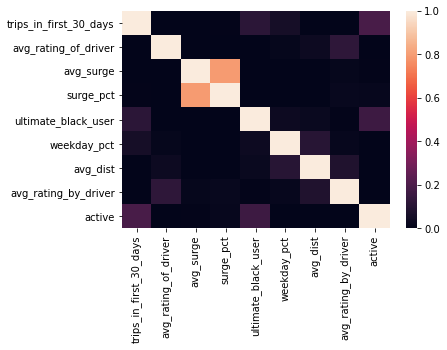

In [17]:
# Plotting correlation matrix is easier with seaborn than bokeh
import seaborn as sns; 
ax = sns.heatmap(data.corr(),vmin=0, vmax=1)

<font color = 'green'>Looks like avg_surge and surge_pct are highly related. This makes sense, because avg_surge is average of surge_pct. We will have to remove these columns while predicting model

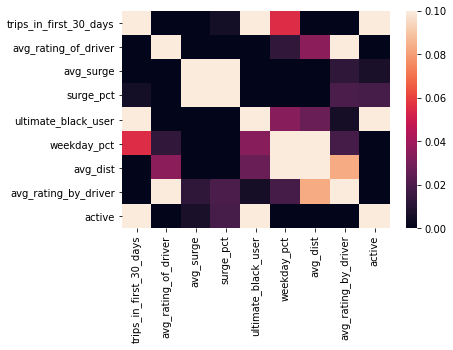

In [18]:
ax = sns.heatmap(data.corr(),vmin=0, vmax=0.1)

<font color='green'> Looking at this correlation matrix we get a rough idea about the columns that can be deleted. 
Being active user is more dependent/correlated on columns trips_in_first_30_days and ultimate_black_user. 


In [19]:
c = data.corr()
c['active'].sort_values()

avg_dist                 -0.087243
avg_rating_by_driver     -0.028296
avg_rating_of_driver     -0.007674
weekday_pct              -0.003444
avg_surge                 0.006715
surge_pct                 0.018740
ultimate_black_user       0.163674
trips_in_first_30_days    0.188372
active                    1.000000
Name: active, dtype: float64

In [20]:
#From above, we could drop avg_dist, avg_rating_by_driver
data.drop(['avg_dist','avg_rating_by_driver','avg_surge','surge_pct'], axis = 1, inplace = True) 


With this knowledge lets start with modeling.
Top 5 binary classification models are -
1. Logistic Regression
2. k-Nearest Neighbors
3. Tree based - Decision Trees / Random Forest / Gradient Boosting 


<font color = 'green'>Given that 24.95% are active, the <b> data is imbalanced. </b>
So, if our model predicts that all are inactive after 6 months, it will be 75% accurate.
So, <b> accuracy is not the right metric </b> for this data. 
Since this is an imbalanced binary classification, we should use a metric that evaluates how good the classifier is in seperating classes. F1 score, ROC and PR curves are good metrics 
For an imbalanced classification, where the number of examples of minority class is small,<b> area under the precision-recall curve is a better metric. It focuses on the performance of the classifier on the minority class </b>


We have to separate features and target columns, split the data into train, test

In [21]:
data['city'].unique()

array(["King's Landing", 'Astapor', 'Winterfell'], dtype=object)

In [22]:
city_values = {"King's Landing": 1, 'Astapor': 2, 'Winterfell': 3}
data_new = data
data_new['city'] = data['city'].replace(city_values)


In [23]:
data_new["ultimate_black_user"] = data_new["ultimate_black_user"].astype(int)
data_new

city  trips_in_first_30_days  avg_rating_of_driver  \
0         1                       4                   4.7   
1         2                       0                   5.0   
2         2                       3                   4.3   
3         1                       9                   4.6   
4         3                      14                   4.4   
...     ...                     ...                   ...   
49993     2                       3                   4.8   
49994     2                       1                   4.6   
49995     1                       0                   5.0   
49997     3                       0                   5.0   
49998     2                       2                   3.0   

       ultimate_black_user  weekday_pct  active  
0                        1         46.2       0  
1                        0         50.0       0  
2                        0        100.0       0  
3                        1         80.0       1  
4                        0         82.4       0  
...                    ...          ...     ...  
49993                    1         55.6       1  
49994                    0         25.0       0  
49995                    0        100.0       0  
49997                    1        100.0       0  
49998                    0        100.0       0  

[41440 rows x 6 columns]

In [24]:
features = ['city', 'trips_in_first_30_days', 'avg_rating_of_driver','ultimate_black_user','weekday_pct']
target = ['active']
X = data[features]
y = data[target]


In [25]:
X

city  trips_in_first_30_days  avg_rating_of_driver  \
0         1                       4                   4.7   
1         2                       0                   5.0   
2         2                       3                   4.3   
3         1                       9                   4.6   
4         3                      14                   4.4   
...     ...                     ...                   ...   
49993     2                       3                   4.8   
49994     2                       1                   4.6   
49995     1                       0                   5.0   
49997     3                       0                   5.0   
49998     2                       2                   3.0   

       ultimate_black_user  weekday_pct  
0                        1         46.2  
1                        0         50.0  
2                        0        100.0  
3                        1         80.0  
4                        0         82.4  
...                    ...          ...  
49993                    1         55.6  
49994                    0         25.0  
49995                    0        100.0  
49997                    1        100.0  
49998                    0        100.0  

[41440 rows x 5 columns]

In [26]:
y

active
0           0
1           0
2           0
3           1
4           0
...       ...
49993       1
49994       0
49995       0
49997       0
49998       0

[41440 rows x 1 columns]

In [27]:
#Split into  train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [28]:
len(X_train), len(X_test), len(y_train), len(y_test)

(27764, 13676, 27764, 13676)

In [53]:
y_test.value_counts() # just for reference 

active
0         10254
1          3422
dtype: int64

/Users/Amulya/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


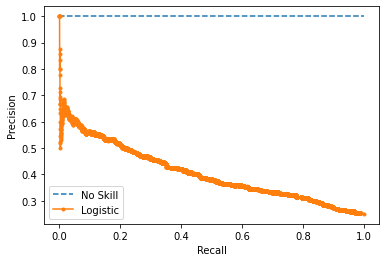

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score, precision_recall_curve


lr = LogisticRegression()
lr.fit(X_train, y_train)
yhat = lr.predict_proba(X_test)
# retrieve just the probabilities for the positive class
pos_probs = yhat[:, 1]
# calculate the no skill line as the proportion of the positive class
no_skill = len(y[y==1]) / len(y)
# plot the no skill precision-recall curve
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
# calculate model precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, pos_probs)
# plot the model precision-recall curve
pyplot.plot(recall, precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [30]:
from sklearn.metrics import auc
# calculate the precision-recall auc
auc_score = auc(recall, precision)
auc_score

0.4050300244662981

<font color='green'>Something is not right. AUC is bad 
Let us check if the data is normally distributed. Because logistic regression, k-nn assumes that X is normally distributed

<AxesSubplot:ylabel='Frequency'>

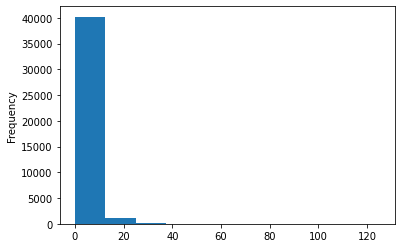

In [29]:
#Lets plot a box plot for the variables and see how it is distributed
#Histogram
data['trips_in_first_30_days'].plot(kind='hist')

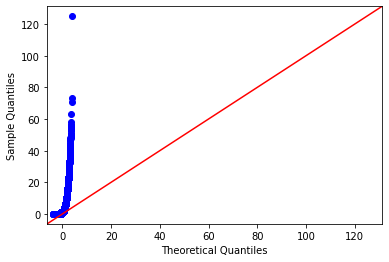

In [30]:
#QQ PLOT
import statsmodels.api as sm
import pylab

my_data = data['trips_in_first_30_days']
sm.qqplot(my_data, line='45')
pylab.show()

<font color ='green'> From just looking at the distribution of one of the variables, we find that it is not normal. Its more so exponentially distributed. 
So,we cannot use logistic regression and k-nn algorithms. Because these assume that the data is normally distributed.

In [31]:
# Building Decision Tree
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(criterion = 'entropy', random_state = 42)
dt.fit(X_train, y_train)
dt_pred_train = dt.predict(X_train)

# Evaluation on Training set
dt_pred_train = dt.predict(X_train)
print('Training Set Evaluation F1-Score=>',f1_score(y_train,dt_pred_train))

Training Set Evaluation F1-Score=> 0.7846815834767642


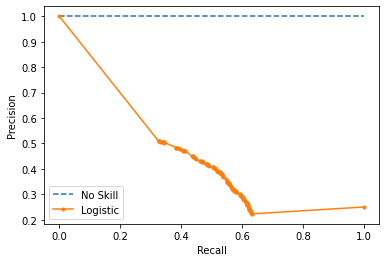

In [32]:
yhat = dt.predict_proba(X_test)
# retrieve just the probabilities for the positive class
pos_probs = yhat[:, 1]
# calculate the no skill line as the proportion of the positive class
no_skill = len(y[y==1]) / len(y)
# plot the no skill precision-recall curve
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
# calculate model precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, pos_probs)
# plot the model precision-recall curve
pyplot.plot(recall, precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [33]:
# Evaluating on Test set
dt_pred_test = dt.predict(X_test)
print('Testing Set Evaluation F1-Score=>',f1_score(y_test,dt_pred_test))

Testing Set Evaluation F1-Score=> 0.40984743411927876


In [34]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, dt_pred_test)

0.7510968119333138

In [35]:
params = {
    'criterion': ['gini', 'entropy'], 
    'splitter': ['best', 'random'],
    'max_depth': [3,4,5,6],
    'max_features': [2,3,4,5],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [4, 8, 10, 12]
}

grid_search_dt = GridSearchCV(dt, param_grid=params)
grid_search_dt.fit(X_train, y_train)

best_dt = grid_search_dt.best_estimator_
print("Best values for parameters: ", grid_search_dt.best_params_)
print("Best score with these parameters: ", grid_search_dt.best_score_)

best_grid_dt = grid_search_dt.best_estimator_
best_grid_dt

Best values for parameters:  {'criterion': 'gini', 'max_depth': 6, 'max_features': 5, 'min_samples_leaf': 5, 'min_samples_split': 4, 'splitter': 'best'}
Best score with these parameters:  0.7610213810744872


DecisionTreeClassifier(max_depth=6, max_features=5, min_samples_leaf=5,
                       min_samples_split=4, random_state=42)

In [43]:
best_grid_dt = best_grid_dt.fit(X_train, y_train)
best_predictions_dt = best_grid_dt.predict(X_test)

In [44]:

from sklearn import metrics
print('Accuracy score: ', metrics.accuracy_score(y_test, best_predictions_dt))

Accuracy score:  0.7589207370576192


In [45]:
precision, recall, thresholds = precision_recall_curve(y_test, best_predictions_dt)
# Use AUC function to calculate the area under the curve of precision recall curve
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)

0.4732381951770027


In [52]:
#confusion matrix
confusion_matrix( y_test, best_predictions_dt)

array([[9724,  530],
       [2767,  655]])

<font color ='green'>Decision Trees is not good.

# Random Forest

In [54]:
# Lets try random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

rfc = RandomForestClassifier(criterion = 'gini', random_state = 42)
rfc.fit(X_train, y_train)

# Evaluating on Training set
rfc_pred_train = rfc.predict(X_train)
print('Training Set Evaluation F1-Score=>',f1_score(y_train,rfc_pred_train))

/Users/Amulya/anaconda2/envs/py365/lib/python3.6/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Training Set Evaluation F1-Score=> 0.7915000000000001


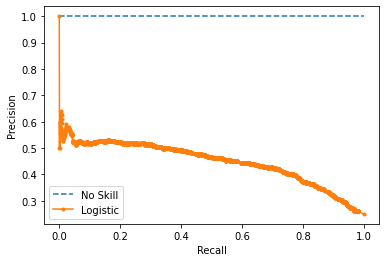

In [55]:
yhat = rfc.predict_proba(X_test)


# retrieve just the probabilities for the positive class
pos_probs = yhat[:, 1]
# calculate the no skill line as the proportion of the positive class
no_skill = len(y[y==1]) / len(y)
# plot the no skill precision-recall curve
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
# calculate model precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, pos_probs)
# plot the model precision-recall curve
pyplot.plot(recall, precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [56]:
# Evaluating on Test set
rfc_pred_test = rfc.predict(X_test)
print('Testing Set Evaluation F1-Score=>',f1_score(y_test,rfc_pred_test))

Testing Set Evaluation F1-Score=> 0.4023129490099877


In [57]:
from sklearn.metrics import average_precision_score, precision_recall_curve
average_precision = average_precision_score(y_test, rfc_pred_test)
print(average_precision)

0.33482234616578205


In [58]:
# Data to plot precision - recall curve
precision, recall, thresholds = precision_recall_curve(y_test, rfc_pred_test)
# Use AUC function to calculate the area under the curve of precision recall curve
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)

0.5020800104551777


In [59]:
from sklearn.model_selection import GridSearchCV
params = { 
    'n_estimators': [100, 200, 300, 400, 600, 800],
    'max_depth': [4,6,8,10],
    'max_features': ['log2','sqrt', 'auto']
}
grid_search = GridSearchCV(rfc, param_grid=params)
grid_search.fit(X_train, y_train)

best = grid_search.best_estimator_
print("Best values for parameters: ", grid_search.best_params_)
print("Best score with these parameters: ", grid_search.best_score_)

best_grid = grid_search.best_estimator_
best_grid

/Users/Amulya/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/Amulya/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/Amulya/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/Amulya/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarni

/Users/Amulya/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/Amulya/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/Amulya/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/Amulya/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarni

/Users/Amulya/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/Amulya/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/Amulya/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/Amulya/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarni

/Users/Amulya/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/Amulya/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/Amulya/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/Amulya/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarni

/Users/Amulya/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/Amulya/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/Amulya/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/Amulya/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarni

/Users/Amulya/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/Amulya/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/Amulya/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/Amulya/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarni

/Users/Amulya/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/Amulya/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/Amulya/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/Amulya/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarni

/Users/Amulya/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/Amulya/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/Amulya/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/Amulya/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarni

/Users/Amulya/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/Amulya/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/Amulya/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/Amulya/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarni

/Users/Amulya/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/Amulya/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/Amulya/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/Amulya/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarni

/Users/Amulya/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/Amulya/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/Amulya/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/Amulya/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarni

/Users/Amulya/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/Amulya/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/Amulya/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/Amulya/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarni

/Users/Amulya/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/Amulya/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/Amulya/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/Amulya/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarni

Best values for parameters:  {'max_depth': 8, 'max_features': 'log2', 'n_estimators': 100}
Best score with these parameters:  0.7669285133409207


RandomForestClassifier(max_depth=8, max_features='log2', random_state=42)

params = { 
    'n_estimators': [100, 200, 300, 400, 600, 800],
    'max_depth': [3,4,5,6],
    'max_features': ['log2','sqrt', 'auto']
}
Best values for parameters:  {'max_depth': 6, 'max_features': 'log2', 'n_estimators': 300}
Best score with these parameters:  0.7774816308889209
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)
params = { 
    'n_estimators': [100, 200, 300, 400, 600, 800],
    'max_depth': [4,6,8,10],
    'max_features': ['log2','sqrt', 'auto']
}
Best values for parameters:  {'max_depth': 10, 'max_features': 'log2', 'n_estimators': 200}
Best score with these parameters:  0.7816597032127935
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [60]:
# Fit with best parameters
best_rf_grid = best_grid.fit(X_train, y_train)
best_rf_predictions = best_rf_grid.predict(X_test)

/Users/Amulya/anaconda2/envs/py365/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


In [61]:
precision, recall, thresholds = precision_recall_curve(y_test, best_rf_predictions)
# Use AUC function to calculate the area under the curve of precision recall curve
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)

0.4842021061850257


In [62]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, best_rf_predictions))

Accuracy: 0.7620649312664521


In [63]:
confusion_matrix( y_test, best_rf_predictions)

array([[9755,  499],
       [2755,  667]])

In [71]:
print('Testing Set Evaluation F1-Score=>',f1_score(y_test,best_rf_predictions))

Testing Set Evaluation F1-Score=> 0.2907585004359198


<font color='green'> Random forest is better than Decision Tree, but still bad

# Gradient Boosting

In [64]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)

# Evaluating on Training set
gb_pred_train = gb.predict(X_train)
print('Training Set Evaluation F1-Score=>',f1_score(y_train,gb_pred_train))

/Users/Amulya/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Training Set Evaluation F1-Score=> 0.38910351659237247


In [66]:
params={'n_estimators': [80,120, 200],
'min_samples_leaf':[10,20,40],
'max_features':['log2','sqrt','auto'],
'subsample':[0.8,1]}
grid_search_gb = GridSearchCV(gb, param_grid=params)
grid_search_gb.fit(X_train, y_train)

best_gb = grid_search_gb.best_estimator_
print("Best values for parameters: ", grid_search_gb.best_params_)
print("Best score with these parameters: ", grid_search_gb.best_score_)

best_grid_gb = grid_search_gb.best_estimator_
best_grid_gb

/Users/Amulya/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/Amulya/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/Amulya/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/Amulya/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

/Users/Amulya/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/Amulya/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/Amulya/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/Amulya/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

/Users/Amulya/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/Amulya/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/Amulya/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/Amulya/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

/Users/Amulya/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/Amulya/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/Amulya/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/Amulya/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

/Users/Amulya/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/Amulya/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/Amulya/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/Amulya/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

/Users/Amulya/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/Amulya/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/Amulya/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/Amulya/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

/Users/Amulya/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/Amulya/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/Amulya/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/Amulya/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

/Users/Amulya/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/Amulya/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/Amulya/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/Amulya/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

/Users/Amulya/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/Amulya/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/Amulya/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/Amulya/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

Best values for parameters:  {'max_features': 'auto', 'min_samples_leaf': 20, 'n_estimators': 200, 'subsample': 1}
Best score with these parameters:  0.7764011690334327


GradientBoostingClassifier(max_features='auto', min_samples_leaf=20,
                           n_estimators=200, subsample=1)

Best values for parameters:  {'max_features': 'auto', 'min_samples_leaf': 20, 'n_estimators': 120, 'subsample': 1}
Best score with these parameters:  0.7744921481054603
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features='auto', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=20, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=120,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1, tol=0.0001, validation_fraction=0.1, verbose=0,
              warm_start=False)

Best values for parameters:  {'max_features': 'auto', 'min_samples_leaf': 20, 'n_estimators': 200, 'subsample': 1}
Best score with these parameters:  0.7755726840512894
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features='auto', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=20, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1, tol=0.0001, validation_fraction=0.1, verbose=0,
              warm_start=False)

In [67]:
# Fit with best parameters
best_grid_gb.fit(X_train, y_train)
best_gb_predictions = best_grid_gb.predict(X_test)

/Users/Amulya/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [68]:
precision, recall, thresholds = precision_recall_curve(y_test, best_gb_predictions)
# Use AUC function to calculate the area under the curve of precision recall curve
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)

0.5321854569779537


In [69]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, best_gb_predictions))

Accuracy: 0.7723749634396022


In [70]:
confusion_matrix(y_test, best_gb_predictions)

array([[9531,  723],
       [2390, 1032]])

In [72]:
print('Testing Set Evaluation F1-Score=>',f1_score(y_test,best_gb_predictions))

Testing Set Evaluation F1-Score=> 0.39868649797179834


<font color='green'>Gradient Boosting is better than random forest, but still bad. 
All the methods we have tried so far is not showing good results. Which implies 
<b>
1. There is something wrong/missing in the data.
2. I am doing something seriously wrong </b> </font>
<br>
<font color='blue'><b> In the notebook ultimate_part3_predictive_modeling, I have performed more preprocessing like one-hot encoding, PCA and normalization before modeling. Though the results are not great, Random forest has performed way better than here. </b></font>

<font color ='red'>3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its longterm rider retention (again, a few sentences will suffice)

<font color='green'>Riders can be retained by sending out more marketing emails with coupons and discounts to people who we think are not going to be active


<font color='green'>The metrics have not been helpful in deciding a better model, so looking at the numbers is the next best option.
Confusion matrix helps us decide which model is better. 
<b>False Positive => </b> actually not active, predicted active. We will miss out sending marketing emails to them. Which is not good.
<b>False Negative => </b> actually active, predicted not active. We will send out emails to people who are active. 
<b>So the model with least False positive and False negative is better.</b>
Going by this assumption - Gradient boosting model is better. But, by following this , we miss sending marketing emails out to more people (730 lost opportunity). But we send less coupons and discounts to active people, thereby reducing expense. 

So <b>depending on marketing budget</b>, we can pick the model
If we are ok spending more by sending discounts to active people(chances of being active is more), we can pick gradient boosting model.

If we are in tight budget, we can pick random forest, because it has less False Positive and False negatives. There by we spend less. 